In [33]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms


import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm


device='cpu'

In [34]:
df = pd.read_csv(".\\datasets\\chexpertchestxrays-u20210408\\train_visualCheXbert.csv")

label_cols = df.columns.tolist()[5:]

# Initialize result dictionary
class_stats = {
    "Class": [],
    "Positives": [],
    "Negatives": [],
    "%": [],
    "Total (non-null)": []
}

# Calculate stats per class
for col in label_cols:
    positives = (df[col] == 1).sum()
    negatives = (df[col] == 0).sum()
    total = df[col].notna().sum()
    
    class_stats["Class"].append(col)
    class_stats["Positives"].append(positives)
    class_stats["Negatives"].append(negatives)
    class_stats["%"].append(positives/(positives+negatives))
    class_stats["Total (non-null)"].append(total)

# Convert to DataFrame
stats_df = pd.DataFrame(class_stats)

stats_df

,Class,Positives,Negatives,%,Total (non-null)
0,No Finding,35526,187888,0.159014,223414
1,Enlarged Cardiomediastinum,143970,79444,0.644409,223414
2,Cardiomegaly,121921,101493,0.545718,223414
3,Lung Opacity,151501,71913,0.678118,223414
4,Lung Lesion,31027,192387,0.138877,223414
5,Edema,94370,129044,0.422400,223414
6,Consolidation,107229,116185,0.479956,223414
7,Pneumonia,52226,171188,0.233763,223414
8,Atelectasis,123924,99490,0.554683,223414
9,Pneumothorax,25339,198075,0.113417,223414


In [35]:
size = (500, 500)

transform_identity = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


BATCHSIZE = 4
# 46 is limit for 24gb

class CheXpertDataset(Dataset):
    def __init__(self, csv_path, image_root, transform, start_index):
        """
        Args:
            csv_path (str): Path to test_labels.csv
            image_root (str): Root directory for images (e.g., 'test/')
            transform (callable): transform to be applied
        """
        self.labels_df = pd.read_csv(csv_path)
        self.image_root = image_root
        self.transform = transform
        self.start_index = start_index

        self.classes = self.labels_df.columns.tolist()[start_index:] # extract the class names 
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx, 0]  # First column is 'Path'
        image = Image.open(f"{self.image_root}/{img_path}")
        image = self.transform(image)
        
        labels = self.labels_df.iloc[idx, self.start_index:].astype(np.float32).values
        labels = torch.from_numpy(labels).float()
                    
        return image, labels, img_path  

val_dataset = CheXpertDataset(
    csv_path=".\\datasets\\chexlocalize_test_val\\CheXpert\\val_labels.csv",
    image_root=".\\datasets\\chexlocalize_test_val\\CheXpert", 
    transform=transform_identity,
    start_index=5
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)


class CheXpertResNet50(nn.Module):
    def __init__(self, pretrained=True, num_classes=14):
        super().__init__()
        # 1. Load pretrained ResNet-50
        backbone = models.resnet50(pretrained=pretrained)

        # 2. Replace the first conv to accept 1 channel
        #    Keep the original weights by summing across the RGB channels
        w = backbone.conv1.weight.data
        # w shape: (64, 3, 7, 7) -> average or sum to (64,1,7,7)
        w_gray = w.sum(dim=1, keepdim=True)  # sum RGB→gray
        new_conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=backbone.conv1.out_channels,
            kernel_size=backbone.conv1.kernel_size,
            stride=backbone.conv1.stride,
            padding=backbone.conv1.padding,
            bias=backbone.conv1.bias is not None
        )
        new_conv1.weight.data.copy_(w_gray)
        if backbone.conv1.bias is not None:
            new_conv1.bias.data.copy_(backbone.conv1.bias.data)

        # 3. Build feature extractor up through layer4
        self.features = nn.Sequential(
            new_conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
        )

        # 4. Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # 5. Classifier head
        self.classifier = nn.Sequential(
            nn.Flatten(),                 
            nn.Dropout(p=0.2),            
            nn.Linear(backbone.layer4[-1].conv3.out_channels, num_classes),
            # nn.Sigmoid()
        )

        # 6. Expose layer4[-1] for Grad-CAM hooks
        self.gradcam_target = backbone.layer4[-1]

        # placeholders for hooks
        self.activations = None
        self.gradients   = None

        # register hooks
        def forward_hook(module, inp, out):
            # out: Tensor shape (B, C, H', W')
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            # grad_out[0]: same shape as activations
            self.gradients = grad_out[0].detach()

        self.gradcam_target.register_forward_hook(forward_hook)
        self.gradcam_target.register_full_backward_hook(backward_hook)

    def forward(self, x):
        """
        x: (B, 1, H, W) grayscale images
        """
        x = self.features(x)            # -> (B, 2048, h', w')
        # self.activations = x            # for Grad-CAM
        x = self.global_pool(x)         # -> (B, 2048, 1, 1)
        x = self.classifier(x)          # -> (B, 14)
        return x

model = CheXpertResNet50()
model.to(device)
model.load_state_dict(torch.load("e2_chexpert_resnet50.sav", map_location=device))

c:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [52]:

@torch.no_grad()
def suitable_name_here(loader, class_idx, class_name=""):
    model.eval()

    all_labels = []
    all_preds = []
    
    # for images, labels, _ in loader:
    for images, labels, _ in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        # loss = criterion(logits, labels)
        
        # running_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(logits).cpu()

        all_preds.append(preds)
        all_labels.append(labels)

    # Stack everything
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Extract specific class
    y_true = all_labels[:, class_idx]
    y_prob = all_preds[:, class_idx]

    # Create a DataFrame for easy plotting
    # Create DataFrame and ensure label is int (for palette keys)
    df = pd.DataFrame({
        'True Label': y_true.int(),
        'Predicted Prob': y_prob
    })

    # Plotting
    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    sns.violinplot(
        x='True Label',
        y='Predicted Prob',
        data=df,
        inner=None,
        linewidth=0,
        hue='True Label',
        palette={0: 'red', 1: 'blue'},
        legend=False,
        ax=ax,
        alpha=0.2
    )

    # sns.stripplot(
    #     x='True Label',
    #     y='Predicted Prob',
    #     data=df,
    #     color='blue',
    #     alpha=0.3,
    #     # jitter=0.15,
    #     ax=ax
    # )
    
    sns.scatterplot(
        data=df,
        x='True Label', y='Predicted Prob',
        alpha=0.2,
        edgecolor=None,
        ax=ax
    )

    ax.set_title(f"Prediction Distribution for {class_name or f'Class {class_idx}'}")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['True = 0', 'True = 1'])
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

100%|██████████| 59/59 [00:21<00:00,  2.71it/s]


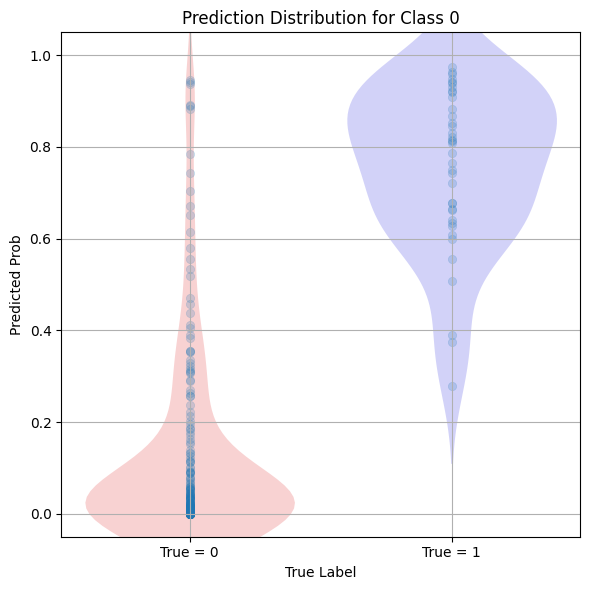

In [53]:
suitable_name_here(
    val_loader,
    class_idx=0,  # e.g. "No Finding"
)